# Calculate cosine similarity by noise ablation on embeddings

This notebook walks through extracting generated embeddings from noise ablation and calculating per-chip cosine similarity between the base embeddings and different types of ablation. These are then aggregated per class to quantify how sensitive the embeddings of each class are for each model to different bands. A KS test is applied to test whether ablated embeddings are significantly different from non-ablated embeddings.

In [1]:
# imports
from gelos.embedding_extraction import extract_embeddings
from gelos.tsne_transform import tsne_from_embeddings, save_tsne_as_csv
from gelos.plotting import plot_from_tsne, legend_patches
from gelos.embedding_generation import perturb_args_to_string
import geopandas as gpd
import yaml
from gelos.config import PROJ_ROOT, PROCESSED_DATA_DIR, DATA_VERSION, RAW_DATA_DIR
from gelos.config import REPORTS_DIR, FIGURES_DIR
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from scipy.stats import ks_2samp

2025-12-10 16:40:34.662 | INFO     | gelos.config:<module>:16 - PROJ_ROOT path is: /app
/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


## Define parameters for embedding extraction from multiple ablation types

In [2]:
model_name = "prithvieov2300"

## Extract embeddings and calculate cosine similarity between ablated embeddings and non-ablated embeddings

In [3]:
yaml_dir = PROJ_ROOT / "gelos" / "configs"
yaml_paths = list(yaml_dir.glob(f"*{model_name}*"))
embeddings_dict = {}
for yaml_path in yaml_paths:
    print(f"pricessing{yaml_path}")
    with open(yaml_path, "r") as f:
        yaml_config = yaml.safe_load(f)
    # print(yaml.dump(yaml_config))

    data_root = RAW_DATA_DIR / DATA_VERSION
    chip_gdf = gpd.read_file(data_root / 'gelos_chip_tracker.geojson')
    figures_dir = FIGURES_DIR / DATA_VERSION
    figures_dir.mkdir(exist_ok=True, parents=True)

    model_name = yaml_config['model']['init_args']['model']
    model_title = yaml_config['model']['title']
    embedding_extraction_strategies = yaml_config['embedding_extraction_strategies']
    perturb = yaml_config['data']['init_args'].get('perturb_bands', None)
    perturb_string = perturb_args_to_string(perturb)
    output_dir = PROCESSED_DATA_DIR / DATA_VERSION / model_name / perturb_string

    embeddings_directories = [item for item in output_dir.iterdir() if item.is_dir()]
    for embeddings_directory in embeddings_directories:
        embedding_layer = embeddings_directory.stem
        extraction_strategy = "CLS Token"
        slice_args = embedding_extraction_strategies[extraction_strategy]

        model_title_lower = model_title.replace(" ", "").lower()
        extraction_strategy_lower = extraction_strategy.replace(" ", "").lower()
        embedding_layer_lower = embedding_layer.replace("_", "").lower()
        print(f"processing embeddings for {perturb_string}")

        embeddings, chip_indices = extract_embeddings(
            embeddings_directory,
            slice_args=slice_args
            )
        embeddings_dict[perturb_string] = embeddings


pricessing/app/gelos/configs/prithvieov2300_blueperturb.yaml
processing embeddings for s2l2ablue0.1perturb
processing embeddings for s2l2ablue0.1perturb


Processing embeddings: 60507it [03:27, 291.02it/s]
Processing embeddings: 60507it [03:27, 291.02it/s]


pricessing/app/gelos/configs/prithvieov2300_noperturb.yaml
processing embeddings for noperturb
processing embeddings for noperturb


Processing embeddings: 60507it [03:51, 261.69it/s]
Processing embeddings: 60507it [03:51, 261.69it/s]


pricessing/app/gelos/configs/prithvieov2300_nirperturb.yaml
processing embeddings for s2l2anir_narrow0.1perturb
processing embeddings for s2l2anir_narrow0.1perturb


Processing embeddings: 60507it [04:43, 213.29it/s]
Processing embeddings: 60507it [04:43, 213.29it/s]


In [5]:
cosine_simalarities = {}
for perturb in embeddings_dict.keys():
    if perturb == "noperturb":
        continue
    perturb_embeddings = embeddings_dict[perturb]
    control_embeddings = embeddings_dict["noperturb"]
    n_samples = control_embeddings.shape[0]
    cosine_simalarities[perturb] = np.array([
        cosine_similarity(perturb_embeddings[i, :].reshape(1, -1), control_embeddings[i, :].reshape(1, -1)).diagonal()
        for i in tqdm(range(n_samples))
    ])

100%|██████████| 60507/60507 [00:16<00:00, 3670.32it/s]



In [34]:
ablation_title_dict = {
    "s2l2ablue0.1perturb": "S2L2A Blue Perturbed with 10% Noise",
    "s2l2anir_narrow0.1perturb": "S2L2A NIR Narrow Perturbed with 10% Noise",
}

In [35]:
for ablation, similarities in cosine_simalarities.items():
    chip_gdf[ablation_title_dict[ablation]] = similarities

## Visualize per-class cosine similarity based on ablated and non-ablated embeddings, with KS test for statistical significance

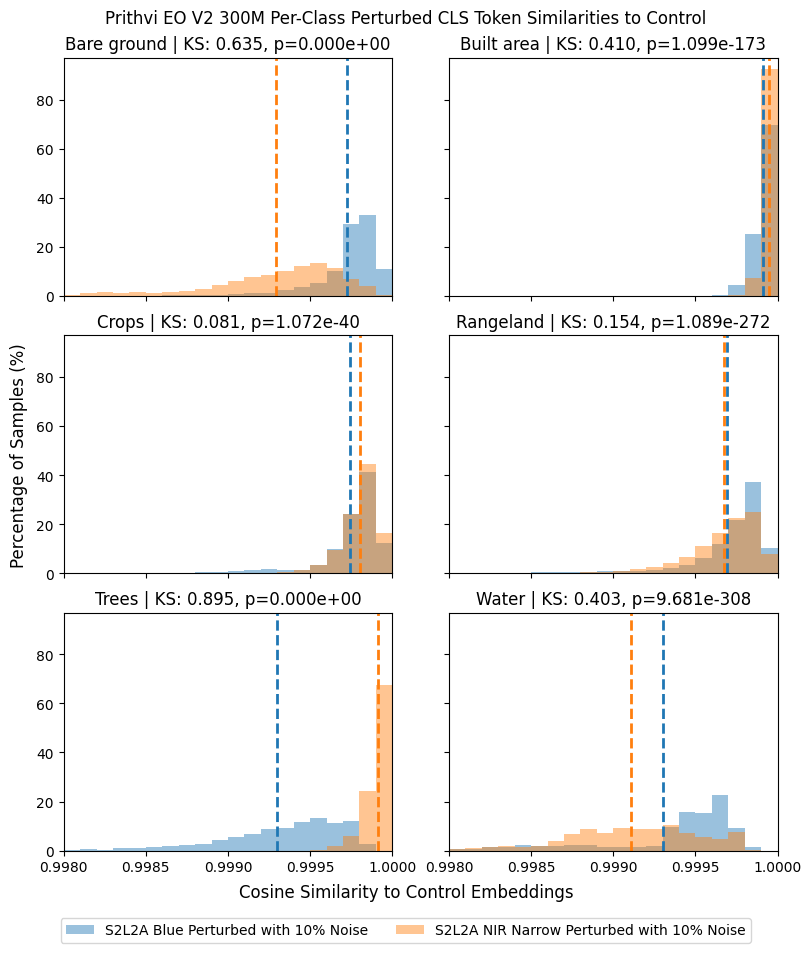

In [38]:
cols = list(ablation_title_dict.values())
categories = sorted(chip_gdf["category"].unique())
n_categories = len(categories)
nrows = int(np.ceil(np.sqrt(n_categories)))
ncols = int(np.ceil(n_categories / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True, constrained_layout=True)
axes = np.atleast_1d(axes).reshape(-1)
color_cycle = plt.cm.tab10(np.arange(len(cols)))
bin_edges = np.linspace(0.998, 1.0, 21)

for idx, category in enumerate(categories):
    ax = axes[idx]
    category_df = chip_gdf[chip_gdf["category"] == category]
    for col, color in zip(cols, color_cycle):
        values = category_df[col].to_numpy()
        if values.size == 0:
            continue
        percent_weights = np.full(values.shape, 100 / values.size, dtype=float)
        ax.hist(values, bins=bin_edges, weights=percent_weights, alpha=0.45, color=color, label=col if idx == 0 else None)
        ax.axvline(values.mean(), color=color, linestyle="--", linewidth=2)
    ks_stat, ks_p = ks_2samp(category_df[cols[0]], category_df[cols[1]])
    ax.set_title(f"{category} | KS: {ks_stat:.3f}, p={ks_p:.3e}")
    ax.set_xlim(0.998, 1)

for ax in axes[n_categories:]:
    ax.axis("off")

fig.supxlabel("Cosine Similarity to Control Embeddings")
fig.supylabel("Percentage of Samples (%)")
plt.suptitle(f"{model_title} Per-Class Perturbed CLS Token Similarities to Control")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=len(cols))
plt.savefig(figures_dir / f"{model_title_lower}_{extraction_strategy_lower}_{embedding_layer_lower}_perturbsimilarity.png")
# plt.close(fig)

## Save results to csv